#### Load packages and functions

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
import numpy as np
import pickle

def getSubDat(cellsMeta, cellsCount, name, norm):
    sampIds = cellsMeta[[name in samp for samp in cellsMeta["sample"].values]].reset_index()
    getDat = cellsCount[[samp for samp in sampIds["qp_well_fq"]]].copy()
    getDat['gene_id'] = cellsCount['gene_id']
    getDat = getDat.set_index('gene_id')
    if norm == 1:
        for i in range(0,len(getDat.columns)):
            getDat.iloc[:,i] = getDat.iloc[:,i]*(1E6/getDat.iloc[:,i].sum())
    getDat.columns = [sampName + '-' + sampIds["qp_well_fq"][i] for i,sampName in enumerate(sampIds["sample"])] 
    getDat = getDat.sort_index()
    return getDat

## Load gene info

In [2]:
glia = pd.read_csv('geneIDs\\glia.csv')

transmitters = pd.read_csv('geneIDs\\transmitters.csv')
receptors = pd.read_csv('geneIDs\\receptors.csv')

VgatedChannels = pd.read_csv('geneIDs\\VgatedChannels.csv')
innexins = pd.read_csv('geneIDs\\innexins.csv')

neuropeptides = pd.read_csv('geneIDs\\neuropeptides.csv')
GPCRs = pd.read_csv('geneIDs\\GPCRs.csv')

NOreceptors = pd.read_csv('geneIDs\\NOreceptors.csv')

## Load RNA Seq data

### Load the bulk data

In [3]:
# Load the counts and key
bulkDat1 = pd.read_csv('data\\180914_NB551104_0096_AHCCTVAFXY_consolidated.FPKM.genes.updated.txt',delimiter='\t')
bulkDat2 = pd.read_csv('data\\181114_NB551104_0107_AHCFK2BGX9_consolidated.FPKM.genes.updated.txt',delimiter='\t')
bulkDat3 = pd.read_csv('data\\181121_NB551104_0109_AHF2CMAFXY_consolidated.FPKM.genes.updated.txt',delimiter='\t')
bulkDat4 = pd.read_csv('data\\171116_NB551104_0039_AHWYH3BGX3_consolidated.FPKM.genes.updated.txt',delimiter='\t')

bulkDat_All = pd.concat([bulkDat1, bulkDat2.iloc[:,3:], bulkDat3.iloc[:,3:], bulkDat4.iloc[:,3:]], axis = 1).set_index('gene_id')

bulkKey = pd.read_csv('data\\all_sample_key.txt',delimiter='\t',header=None)
bulkKey.columns = ['sample','line']

# Specify the order to lines to look at
lines = ['SS00096', 'SS00131', 'SS02191', 'SS02238', 'SS30295','SS02232','SS02233','5ng_flybrain']

# Load the bulk cell dat for each line
bulkSeq = pd.DataFrame()
for ln in lines:
    sampNames = [bulkKey['sample'][i] for i, val in enumerate(bulkKey['line']) if ln in val]
    datNow = bulkDat_All[sampNames]
    datNow.columns = [nm for nm in bulkKey['line'] if ln in nm]
    bulkSeq = pd.concat([bulkSeq,datNow],axis=1)
bulkSeq.columns = ['E-PG_l1r1','E-PG_l1r2','E-PG_l2r1','E-PG_l2r2',
                   'P-EG_r1','P-EG_r2',
                   'D7_l1r1','D7_l1r2','D7_l2r1','D7_l2r2',
                   'P-EN2_l1r1','P-EN2_l2r1',
                   'wholebrain_1', 'wholebrain_2']

# Save the data as a csv file to load into the R script
bulkSeq.to_csv('data//bulkSeq.csv', sep=',')

### Load the low cell and single cell data

In [4]:
cellsMeta = pd.read_csv('data\\merged_sample_info.txt',delimiter='\t')
cellsCount = pd.read_csv('data\\merged_counts.txt',delimiter='\t')

### Get the low cell data

In [5]:
PEN2s_lowCell = getSubDat(cellsMeta, cellsCount,"SS02232_35c",1)
R4ds_lowCell = getSubDat(cellsMeta, cellsCount,"SS00238",1)
wholeBrain_lowCell = getSubDat(cellsMeta, cellsCount,"50pg_CBqRNA",1)

# Combine the low cell data into one dataframe
lowCellSeq = pd.concat([PEN2s_lowCell,R4ds_lowCell,wholeBrain_lowCell], axis=1, join='inner')
lowCellSeq.columns = ['P-EN2_r1','P-EN2_r2','P-EN2_r3','P-EN2_r4','P-EN2_r5','P-EN2_r6','P-EN2_r7',
                      'P-EN2_r8','P-EN2_r9','P-EN2_r10','P-EN2_r11','P-EN2_r12','P-EN2_r13','P-EN2_r14',
                      'ring_r1','ring_r2','ring_r3','ring_r4','ring_r5','ring_r6','ring_r7',
                      'wholebrain_r1','wholebrain_r2','wholebrain_r3','wholebrain_r4',
                      'wholebrain_r5','wholebrain_r6','wholebrain_r7','wholebrain_r8']
lowCellSeqMean = pd.concat([PEN2s_lowCell.mean(axis=1), R4ds_lowCell.mean(axis=1), wholeBrain_lowCell.mean(axis=1)],
                           axis = 1, join = 'inner').rename(columns={0: "P-EN2", 1: "R4d", 2: "wholeBrain"})

# Save the data as a csv file to load into the R script
lowCellSeq.to_csv('data//lowCellSeq.csv', sep=',')

### Get the single cell data

In [6]:
PEN1s_singleCell = getSubDat(cellsMeta, cellsCount,"62862_CB_facs",0)
PEN2s_singleCell = getSubDat(cellsMeta, cellsCount,"02232_CB_facs",0)
wholeBrain_singleCell = getSubDat(cellsMeta, cellsCount,"qRNA_CB_10pg",0)
ERCCs_singleCell = getSubDat(cellsMeta, cellsCount,"ERCC",0)

### Filter the single cell data

In [7]:
PEN1_plates = [389,391,392,394,395,396]
PEN2_plates = [386,387,388,390,393]

#### Threshold 1: Select the single cells where more genes are detected than in the ERCC alone wells.

In [8]:
# Get all of the PEN1 ERCC controls
PEN1_ERCCs = [[nm for nm in ERCCs_singleCell.columns if str(plt) in nm] for plt in PEN1_plates]
PEN1_ERCCs = [item for sublist in PEN1_ERCCs for item in sublist]
PEN1_ERCCs = ERCCs_singleCell[PEN1_ERCCs]

# Get all of the PEN2 ERCC controls
PEN2_ERCCs = [[nm for nm in ERCCs_singleCell.columns if str(plt) in nm] for plt in PEN2_plates]
PEN2_ERCCs = [item for sublist in PEN2_ERCCs for item in sublist]
PEN2_ERCCs = ERCCs_singleCell[PEN2_ERCCs]

# Threshold
thresh1_PEN1 = [PEN1s_singleCell.columns[i] for i,val in enumerate(PEN1s_singleCell.sum()) if val > PEN1_ERCCs.sum().max()]
thresh1_PEN2 = [PEN2s_singleCell.columns[i] for i,val in enumerate(PEN2s_singleCell.sum()) if val > PEN2_ERCCs.sum().max()]

#### Threshold 2: Select the single cells that are within 2 SD of the mean for number of ERCC genes detected

In [9]:
thresh2_PEN1 = []
for plate in PEN1_plates:
    PEN1_wells = [nm for nm in PEN1s_singleCell.columns if str(plate) in nm]
    PEN1_plate_dat = PEN1s_singleCell[PEN1_wells]
    ERCCs_det_plate = [sum(sum([PEN1_plate_dat[w].loc[
        [i for i in PEN1_plate_dat.index if 'ERCC' in i]] > 0]))
                       for w in PEN1_wells]
    thresh2_PEN1.append([PEN1_wells[l] for l,val in  enumerate(ERCCs_det_plate) 
                         if val > (np.mean(ERCCs_det_plate) - 2*np.std(ERCCs_det_plate)) and
                         val < (np.mean(ERCCs_det_plate) + 2*np.std(ERCCs_det_plate))])   
thresh2_PEN1 = [item for sublist in thresh2_PEN1 for item in sublist]

thresh2_PEN2 = []
for plate in PEN2_plates:
    PEN2_wells = [nm for nm in PEN2s_singleCell.columns if str(plate) in nm]
    PEN2_plate_dat = PEN2s_singleCell[PEN2_wells]
    ERCCs_det_plate = [sum(sum([PEN2_plate_dat[w].loc[
        [i for i in PEN2_plate_dat.index if 'ERCC' in i]] > 0]))
                       for w in PEN2_wells]
    thresh2_PEN2.append([PEN2_wells[l] for l,val in  enumerate(ERCCs_det_plate) 
                         if val > (np.mean(ERCCs_det_plate) - 2*np.std(ERCCs_det_plate)) and
                         val < (np.mean(ERCCs_det_plate) + 2*np.std(ERCCs_det_plate))])   
thresh2_PEN2 = [item for sublist in thresh2_PEN2 for item in sublist]

#### Combine the different thresholds

In [10]:
thresh_PEN1 = [t for t in thresh1_PEN1 if t in thresh2_PEN1]
thresh_PEN2 = [t for t in thresh1_PEN2 if t in thresh2_PEN2]

#### Select only the data that passes the threshold and normalize

In [11]:
PEN1s_singleCell = PEN1s_singleCell[thresh_PEN1]
for i in range(0,len(PEN1s_singleCell.columns)):
    PEN1s_singleCell.iloc[:,i] = PEN1s_singleCell.iloc[:,i]*(1E6/PEN1s_singleCell.iloc[:,i].sum())

PEN2s_singleCell = PEN2s_singleCell[thresh_PEN2]
for i in range(0,len(PEN2s_singleCell.columns)):
    PEN2s_singleCell.iloc[:,i] = PEN2s_singleCell.iloc[:,i]*(1E6/PEN2s_singleCell.iloc[:,i].sum())

#### Find the average counts across samples for the single cell data

In [12]:
PEN1Mean = PEN1s_singleCell.mean(axis=1)
PEN2Mean = PEN2s_singleCell.mean(axis=1)
wholeBrainMean = wholeBrain_singleCell.mean(axis=1)

singleCellSeqMean = pd.concat([PEN1Mean, PEN2Mean,wholeBrainMean], axis=1, join='inner')
singleCellSeqMean = singleCellSeqMean.rename(columns={0: "P-EN1", 1: "P-EN2", 2: "wholeBrain"})

## Plot the data

In [13]:
def pltHtMap(genes,counts,cLabel,maxCts):

    lookAtGenes = counts.loc[genes['gene_id'].values]
    pc = plt.pcolor(np.log10(lookAtGenes.values+1),vmin=0,vmax=maxCts)
    plt.yticks(np.arange(0.5, len(genes), 1), genes["name"],fontsize = 6)
    plt.xticks(np.arange(0.5, len(lookAtGenes.columns)+0.5, 1), lookAtGenes.columns,rotation = 90,fontsize = 6)
    cbar = plt.colorbar(pc)
    cbar.set_label('log10(' + cLabel + '+1)', rotation=270,fontsize = 6)
    cbar.ax.tick_params(labelsize=6)

#### Figure 2

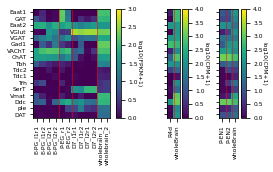

In [14]:
genes2plt = transmitters.iloc[0:17,]

fig = plt.figure(figsize=[4,2])
gs = fig.add_gridspec(1,4)
rcParams['svg.fonttype'] = 'none'

ax1 = fig.add_subplot(gs[0, 0:2])
plt1 = pltHtMap(genes2plt,bulkSeq[['E-PG_l1r1','E-PG_l1r2','E-PG_l2r1','E-PG_l2r2',
                   'P-EG_r1','P-EG_r2',
                   'D7_l1r1','D7_l1r2','D7_l2r1','D7_l2r2',
                   'wholebrain_1', 'wholebrain_2']],'FPKM',3)
ax1.axvline(x=4, color = 'r',linewidth=0.5)
ax1.axvline(x=6, color = 'r',linewidth=0.5)
ax1.axvline(x=10, color = 'r',linewidth=0.5)
ax1.set_aspect('equal')

ax2 = fig.add_subplot(gs[0,2])
plt2 = pltHtMap(genes2plt,lowCellSeqMean[['R4d','wholeBrain']],'CPM',4)
ax2.axvline(x=1, color = 'r',linewidth=0.5)
ax2.set_aspect('equal')
ax2.tick_params(axis='y',labelleft=False) 

ax3 = fig.add_subplot(gs[0,3])
plt3 = pltHtMap(genes2plt,singleCellSeqMean,'CPM',4)
ax3.axvline(x=1, color = 'r',linewidth=0.5)
ax3.axvline(x=2, color = 'r',linewidth=0.5)
ax3.set_aspect('equal')
ax3.tick_params(axis='y',labelleft=False) 

plt.show()
    
fig.savefig("plots//transmitters.svg")

#### Figure 3

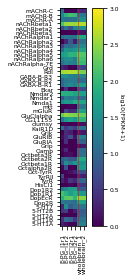

In [15]:
genes2plt = receptors

fig = plt.figure(figsize=[2,4])
rcParams['svg.fonttype'] = 'none'

ax1 = fig.add_subplot()
plt1 = pltHtMap(genes2plt,
                bulkSeq[['E-PG_l1r1','E-PG_l1r2','E-PG_l2r1','E-PG_l2r2',
                         'wholebrain_1', 'wholebrain_2']],
                'FPKM',3)
ax1.axvline(x=4, color = 'r',linewidth=0.5)
ax1.set_aspect('equal')

fig.savefig("plots//EPG_receptors.svg")

#### Figure 5

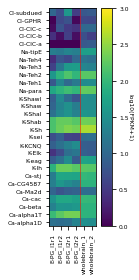

In [16]:
genes2plt = VgatedChannels

fig = plt.figure(figsize=[2,4])
rcParams['svg.fonttype'] = 'none'

ax1 = fig.add_subplot()
plt1 = pltHtMap(genes2plt,
                bulkSeq[['E-PG_l1r1','E-PG_l1r2','E-PG_l2r1','E-PG_l2r2',
                         'wholebrain_1', 'wholebrain_2']],
                'FPKM',3)
ax1.axvline(x=4, color = 'r',linewidth=0.5)
ax1.set_aspect('equal')

fig.savefig("plots//EPG_VgatedChannels.svg")

#### Figure 6

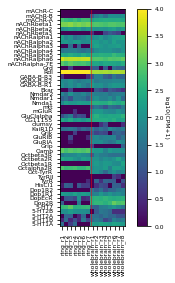

In [17]:
genes2plt = receptors

fig = plt.figure(figsize=[4,4])
rcParams['svg.fonttype'] = 'none'

ax1 = fig.add_subplot()
plt1 = pltHtMap(genes2plt,
                lowCellSeq[['ring_r1','ring_r2','ring_r3','ring_r4','ring_r5','ring_r6','ring_r7',
                      'wholebrain_r1','wholebrain_r2','wholebrain_r3','wholebrain_r4',
                      'wholebrain_r5','wholebrain_r6','wholebrain_r7','wholebrain_r8']],
                'CPM',4)
ax1.axvline(x=7, color = 'r',linewidth=0.5)
ax1.set_aspect('equal')

fig.savefig("plots//ring_receptors.svg")

## Look at the most differentially expressed genes

### Plot the p values
1. Put all the p values into one matrix
2. Determine if the sample counts are greater than or less than the bulk counts
3. Plot the log 10 of the p values, flipping the sign of those where the counts are higher

In [18]:
def names4GenesPVals(dge_table,genesOfInt):
    dge_genes = dge_table['Unnamed: 0']
    dge_pvals = dge_table['PValue']

    geneNames = []
    genePs = []
    for i,gene in enumerate(dge_genes):
        for j,intGene in enumerate(genesOfInt['gene_id']):
            if gene == intGene:
                geneNames.append(genesOfInt['name'][j])
                genePs.append(dge_pvals[i])

    d = {'gene_names': geneNames, 'PValue': genePs}
    return pd.DataFrame(data=d)

#### Load the differential gene expression tables

In [19]:
# bulk
dge_table_EPG_bulk = pd.read_csv('dge\\dge_table_EPG_wholebrain.csv',delimiter=',')
dge_table_PEG_bulk = pd.read_csv('dge\\dge_table_PEG_wholebrain.csv',delimiter=',')
dge_table_D7_bulk = pd.read_csv('dge\\dge_table_D7_wholebrain.csv',delimiter=',')
dge_table_PEN2_bulk = pd.read_csv('dge\\dge_table_PEN2_wholebrain.csv',delimiter=',')

# low cell
dge_table_ring_lowCell = pd.read_csv('dge\\dge_table_ring_wholebrain.csv',delimiter=',')
dge_table_PEN2_lowCell = pd.read_csv('dge\\dge_table_PEN2_wholebrain.csv',delimiter=',')

#### Extract the p-values for the genes of interest and convert to a data frame

In [20]:
# Load the genes of interest
genesOfInt = pd.concat([glia,transmitters,receptors,VgatedChannels,innexins,neuropeptides,GPCRs,NOreceptors]).reset_index()

# bulk
EPG_PVals_bulk = names4GenesPVals(dge_table_EPG_bulk,genesOfInt)
PEG_PVals_bulk = names4GenesPVals(dge_table_PEG_bulk,genesOfInt)
D7_PVals_bulk = names4GenesPVals(dge_table_D7_bulk,genesOfInt)
PEN2_PVals_bulk = names4GenesPVals(dge_table_PEN2_bulk,genesOfInt)

combPVals_bulk = pd.DataFrame({'gene_names':EPG_PVals_bulk['gene_names']})
combPVals_bulk = pd.merge(combPVals_bulk,EPG_PVals_bulk,on='gene_names')
combPVals_bulk = combPVals_bulk.rename(columns = {"PValue":"PValue - EPG"})
combPVals_bulk = pd.merge(combPVals_bulk,PEG_PVals_bulk,on='gene_names')
combPVals_bulk = combPVals_bulk.rename(columns = {"PValue":"PValue - PEG"})
combPVals_bulk = pd.merge(combPVals_bulk,D7_PVals_bulk,on='gene_names')
combPVals_bulk = combPVals_bulk.rename(columns = {"PValue":"PValue - D7"})
combPVals_bulk = pd.merge(combPVals_bulk,PEN2_PVals_bulk,on='gene_names')
combPVals_bulk = combPVals_bulk.rename(columns = {"PValue":"PValue - PEN2"})

# low cell
ring_PVals_lowCell = names4GenesPVals(dge_table_ring_lowCell,genesOfInt)
PEN2_PVals_lowCell = names4GenesPVals(dge_table_PEN2_lowCell,genesOfInt)

combPVals_lowCell = pd.DataFrame({'gene_names':PEN2_PVals_lowCell['gene_names']})
combPVals_lowCell = pd.merge(combPVals_lowCell,PEN2_PVals_lowCell,on='gene_names')
combPVals_lowCell = combPVals_lowCell.rename(columns = {"PValue":"PValue - PEN2_lc"})
combPVals_lowCell = pd.merge(combPVals_lowCell,ring_PVals_lowCell,on='gene_names')
combPVals_lowCell = combPVals_lowCell.rename(columns = {"PValue":"PValue - R4m_lc"})

#### Find the mean expression values across samples

In [21]:
# bulk
EPGMeanVals = bulkSeq[[nm for nm in bulkSeq.columns if 'E-PG' in nm]].mean(axis=1)
PEGMeanVals = bulkSeq[[nm for nm in bulkSeq.columns if 'P-EG' in nm]].mean(axis=1)
D7MeanVals = bulkSeq[[nm for nm in bulkSeq.columns if 'D7' in nm]].mean(axis=1)
PEN2MeanVals = bulkSeq[[nm for nm in bulkSeq.columns if 'P-EN2' in nm]].mean(axis=1)
WBMeanVals = bulkSeq[[nm for nm in bulkSeq.columns if 'wholebrain' in nm]].mean(axis=1)
ctDiffsBulk = pd.DataFrame({'EPGDiff':(EPGMeanVals-WBMeanVals),
                            'PEGDiff':(PEGMeanVals-WBMeanVals),
                            'D7Diff':(D7MeanVals-WBMeanVals),
                            'PEN2Diff':(PEN2MeanVals-WBMeanVals),
                           })
ctDiffsBulk[ctDiffsBulk >= 0] = 0
ctDiffsBulk[ctDiffsBulk < 0] = 1
ctDiffsBulk[ctDiffsBulk == 0] = -1


# low cell
PEN2MeanVals_lc = lowCellSeq[[nm for nm in lowCellSeq.columns if 'P-EN2' in nm]].mean(axis=1)
R4mMeanVals_lc = lowCellSeq[[nm for nm in lowCellSeq.columns if 'ring' in nm]].mean(axis=1)
WBMeanVals_lc = lowCellSeq[[nm for nm in lowCellSeq.columns if 'wholebrain' in nm]].mean(axis=1)
ctDiffsLowCell = pd.DataFrame({'R4mDiff_lc':(R4mMeanVals_lc-WBMeanVals_lc),
                        'PEN2Diff_lc':(PEN2MeanVals_lc-WBMeanVals_lc)
                       })
ctDiffsLowCell[ctDiffsLowCell >= 0] = 0
ctDiffsLowCell[ctDiffsLowCell < 0] = 1
ctDiffsLowCell[ctDiffsLowCell == 0] = -1

##### Specify the genes to consider

In [22]:
geneGps = [transmitters, neuropeptides, receptors, VgatedChannels]
geneNm = ['transmitters','neuropeptides','receptors','VgatedChannels']

#### Plot the low cell data

C:\Users\turnerevansd\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


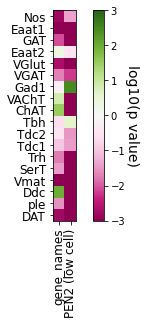

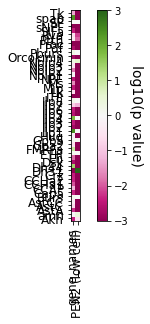

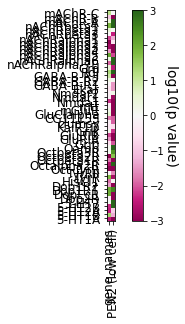

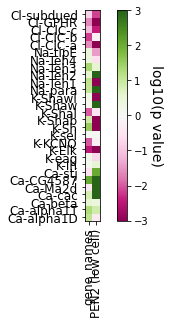

In [23]:
for i,genesToConsider in enumerate(geneGps):

    # Select those values from the p value and signed data frames
    combDat = genesToConsider.rename(columns={'name':'gene_names'})
    combDat = pd.merge(combDat,combPVals_lowCell,on='gene_names')
    combDat = pd.merge(combDat,ctDiffsLowCell.reset_index(),on='gene_id')

    # Manipulate the data for plotting
    pltDat = pd.DataFrame({'gene_names':combDat['gene_names'],
                           'PEN2 (low cell)':(np.log10(combDat['PValue - PEN2_lc'])*combDat['PEN2Diff_lc']),
                           'R4m (low cell)':(np.log10(combDat['PValue - R4m_lc'])*combDat['R4mDiff_lc']),
                          })

    # Plot the low cell data
    fig = plt.figure()
    rcParams['svg.fonttype'] = 'none'

    pc = plt.pcolor(pltDat.iloc[:,1:3],vmin=-3,vmax=3,cmap='PiYG',
               norm = colors.DivergingNorm(vmin=-3., vcenter=0., vmax=3))

    plt.xticks(np.arange(0.5, 2.5, 1), pltDat.columns[0:2],fontsize = 12,rotation=90)
    plt.yticks(np.arange(0.5, len(genesToConsider)), genesToConsider["name"],fontsize = 12)

    cbar = plt.colorbar(pc)
    cbar.set_label('log10(p value)', rotation=270,size=14,labelpad=14)

    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()
    
    fig.savefig("plots//" + geneNm[i] + "_PVals_lowCell.svg")
    

#### Plot the bulk data

C:\Users\turnerevansd\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


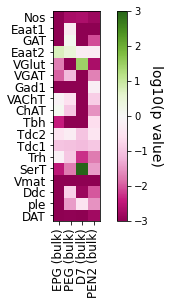

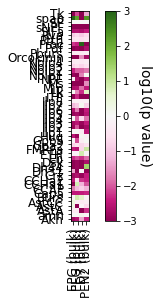

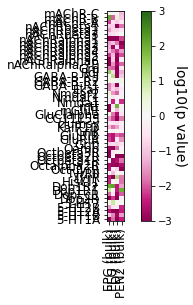

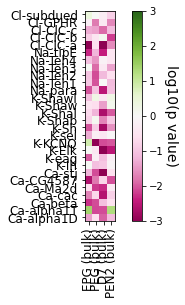

In [24]:
for i,genesToConsider in enumerate(geneGps):

    # Select those values from the p value and signed data frames
    combDat = genesToConsider.rename(columns={'name':'gene_names'})
    combDat = pd.merge(combDat,combPVals_bulk,on='gene_names')
    combDat = pd.merge(combDat,ctDiffsBulk.reset_index(),on='gene_id')

    # Manipulate the data for plotting
    pltDat = pd.DataFrame({'gene_names':combDat['gene_names'],
                           'EPG (bulk)':(np.log10(combDat['PValue - EPG'])*combDat['EPGDiff']),
                           'PEG (bulk)':(np.log10(combDat['PValue - PEG'])*combDat['PEGDiff']),
                           'D7 (bulk)':(np.log10(combDat['PValue - D7'])*combDat['D7Diff']),
                           'PEN2 (bulk)':(np.log10(combDat['PValue - PEN2'])*combDat['PEN2Diff']),
                          })

    # Plot the low cell data
    fig = plt.figure()
    rcParams['svg.fonttype'] = 'none'
    pc = plt.pcolor(pltDat.iloc[:,1:5],vmin=-3,vmax=3,cmap='PiYG',
                   norm = colors.DivergingNorm(vmin=-3., vcenter=0., vmax=3))

    plt.xticks(np.arange(0.5, 4.5, 1), pltDat.columns[1:5],fontsize = 12,rotation=90)
    plt.yticks(np.arange(0.5, len(genesToConsider)), genesToConsider["name"],fontsize = 12)

    cbar = plt.colorbar(pc)
    cbar.set_label('log10(p value)', rotation=270,size=14,labelpad=14)

    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    fig.savefig("plots//" + geneNm[i] + "_PVals_bulk.svg")

#### Pull out relevant p-values

In [25]:
combPVals_lowCell['PValue - R4m_lc'].iloc[[i for i,val in enumerate(combPVals_lowCell['gene_names']) if val == 'Gad1']]

319    0.003172
Name: PValue - R4m_lc, dtype: float64

In [26]:
combPVals_bulk['PValue - D7'].iloc[[i for i,val in enumerate(combPVals_bulk['gene_names']) if val == 'VGlut']]

3215    0.033429
Name: PValue - D7, dtype: float64

In [27]:
combPVals_bulk['PValue - EPG'].iloc[[i for i,val in enumerate(combPVals_bulk['gene_names']) if val == 'GluClalpha']]

3297    0.370895
Name: PValue - EPG, dtype: float64

In [28]:
combPVals_bulk['PValue - EPG'].iloc[[i for i,val in enumerate(combPVals_bulk['gene_names']) if val == 'Nmdar1']]

3317    0.537809
Name: PValue - EPG, dtype: float64

In [29]:
combPVals_bulk['PValue - EPG'].iloc[[i for i,val in enumerate(combPVals_bulk['gene_names']) if val == 'Nmdar2']]

3287    0.272425
Name: PValue - EPG, dtype: float64

In [30]:
combPVals_bulk['PValue - EPG'].iloc[[i for i,val in enumerate(combPVals_bulk['gene_names']) if val == 'mAChR-B']]

3202    0.008478
Name: PValue - EPG, dtype: float64

In [31]:
combPVals_lowCell['PValue - R4m_lc'].iloc[[i for i,val in enumerate(combPVals_lowCell['gene_names']) if val == 'Rdl']]

217    9.891596e-30
Name: PValue - R4m_lc, dtype: float64